In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np

import pickle 
import time
from qiskit.circuit.library import iSwapGate

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from collections import defaultdict
import json

In [76]:
n_qubits = 3

aer = AerSimulator()
estimator_sim = Estimator( mode = aer)
pm_sim = generate_preset_pass_manager(backend=aer, optimization_level=3)


In [77]:

def getOB(n_qubits,J=1,g=0.1,periodic=True):
    H = []
    for i in range(n_qubits-1):
        H.append(("I"*(n_qubits-i-2)+"ZZ"+"I"*i, -J))
        
    if periodic:
        if n_qubits>2:
            H.append(("Z"+"I"*((n_qubits-2))+"Z", -J))

    for i in range(n_qubits):
        H.append(("I"*(n_qubits-i-1)+"X"+"I"*i, -J*g))
        

    observable = SparsePauliOp.from_list(H)

    eigenValues=np.linalg.eig(observable.to_matrix())[0]
    eigenValues.sort()
    groundEnergy=eigenValues[0]
    #print(np.real(groundEnergy))
    return observable, np.real(groundEnergy)



In [107]:
E_list=[]
g_list = np.arange(0,3,0.01)
for g in g_list:
    ob,E = getOB(n_qubits,J=1,g=g)
    E_list.append(E)

E_list = np.array(E_list)


In [103]:
def getD2(E_list,g_list):
    dg = g_list[1]-g_list[0]
    d2 = (E_list[2:]+E_list[:-2]-2*E_list[1:-1])/(dg*dg)
    #get extremum:
    ind_min = np.where(d2==d2.min())[0][0]
    g_min = g_list[1:-1][ind_min]
    return d2,g_min

In [104]:
d2,boundary = getD2(E_list,g_list)

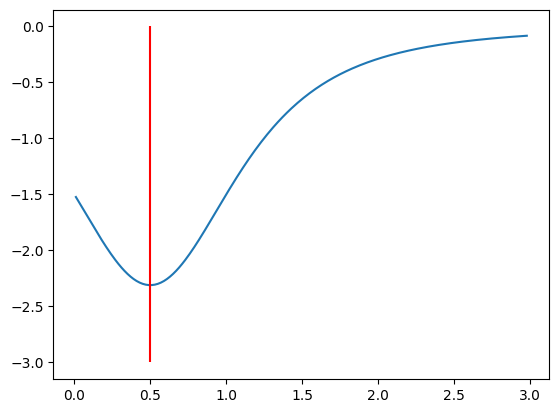

In [106]:
plt.plot(g_list[1:-1],d2)
plt.vlines(boundary,-3,0,color='r')

In [132]:
boundary_list = []
n_q_list = np.arange(2,11,1)
for n_q in n_q_list:
    print(n_q)
    E_list=[]
    if n_q<5:
        g_list = np.arange(0.,1.0,0.02)
    elif n_q<8:
        g_list = np.arange(0.7,1.0,0.02)
    else:
        g_list = np.arange(0.85,1.0,0.02)
    for g in g_list:
        ob,E = getOB(n_q,J=1,g=g)
        E_list.append(E)

    E_list = np.array(E_list)
    d2,boundary = getD2(E_list,g_list)
    boundary_list.append(boundary)
    
boundary_list  = np.array(boundary_list )


2
3
4
5
6
7
8
9
10


In [186]:
from scipy.optimize import curve_fit
def func(x, a,b,c):

    return c-(a/x)**(b)

popt, pcov = curve_fit(func, n_q_list,boundary_list)
a,b,c = popt
print(a,b,c)

1.968716077562535 1.6561380962589305 0.9946168276416446


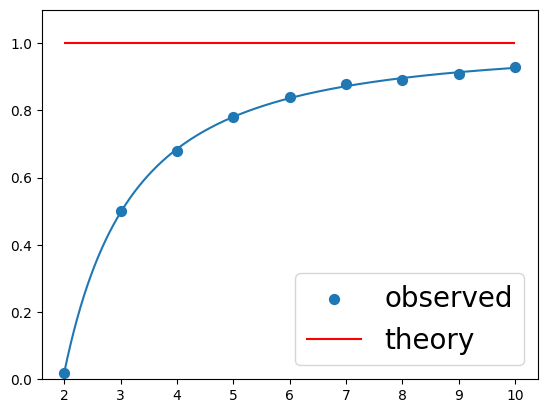

In [187]:
#plt.plot(n_q_list, boundary_list)
plt.scatter(n_q_list, boundary_list,label='observed',s=50)

xxx = np.arange(2,10,0.001)

plt.plot(xxx,func(xxx, a,b,c))
plt.ylim(0,1.1)
plt.hlines(1,2,10,color='r',label='theory')
plt.legend(loc=4,fontsize=20)